In [255]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import ensemble
from sklearn.base import clone
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from pytorch_tabnet.tab_model import TabNetClassifier

sns.set_theme(style='darkgrid')

In [256]:
df = pd.read_csv("income_pred.csv")

In [257]:
class custom_scaler(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler_name = 'minmax'):
        self.scaler_name = scaler_name
        self.scaler = None
        
    def fit(self, X, y=None):
        self.columns = X.columns
        if(self.scaler_name == 'minmax'):
            scaler = MinMaxScaler()
        
        elif (self.scaler_name == 'standard'):
            scaler = StandardScaler()
        
        self.scaler = scaler.fit(X)
        return self
    
    def transform(self, X, y=None):
        names = X.columns
        scaled_data = self.scaler.transform(X)
        X = pd.DataFrame(data=scaled_data, columns=names)
        return X
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

Scaling transformer

In [258]:
df.isnull().sum()

ID                 0
age                0
workclass          0
fnlwgt:            0
education:         0
education-num:     0
marital-status:    0
occupation:        0
relationship:      0
race:              0
sex:               0
capital-gain:      0
capital-loss:      0
hours-per-week:    0
native-country:    0
class              0
dtype: int64

No missing values, no filling transformers needed

In [259]:
df.dtypes

ID                  int64
age                 int64
workclass          object
fnlwgt:             int64
education:         object
education-num:      int64
marital-status:    object
occupation:        object
relationship:      object
race:              object
sex:               object
capital-gain:       int64
capital-loss:       int64
hours-per-week:     int64
native-country:    object
class              object
dtype: object

In [260]:
df['age'].value_counts()

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64

In [261]:
df = df[:-1]

In [262]:
dict = {'fnlwgt:': 'fnlwgt',
        'education:': 'education',
        'education-num:': 'education-num',
        'marital-status:': 'marital-status',
        'occupation:': 'occupation',
        'relationship:': 'relationship',
        'race:': 'race',
        'sex:': 'sex',
        'capital-gain:': 'capital-gain',
        'capital-loss:': 'capital-loss',
        'hours-per-week:': 'hours-per-week',
        'native-country:': 'native-country',
        'class': 'target'
       }
  
# call rename () method
df.rename(columns=dict,
          inplace=True)

In [263]:
df['target']=df['target'].map({'<=50K': 0, '>50K': 1})

Change target value to a binary value

In [264]:
df['target'].value_counts()

0    24720
1     7840
Name: target, dtype: int64

In [265]:
df.loc[df['sex']=='Male', 'sex']=0
df.loc[df['sex']=='Female', 'sex']=1

Binarizing sex

In [266]:
df['sex'].value_counts()

0    21790
1    10770
Name: sex, dtype: int64

Seems there are twice men than women, should check with relationship to confirm.

<AxesSubplot:xlabel='relationship', ylabel='count'>

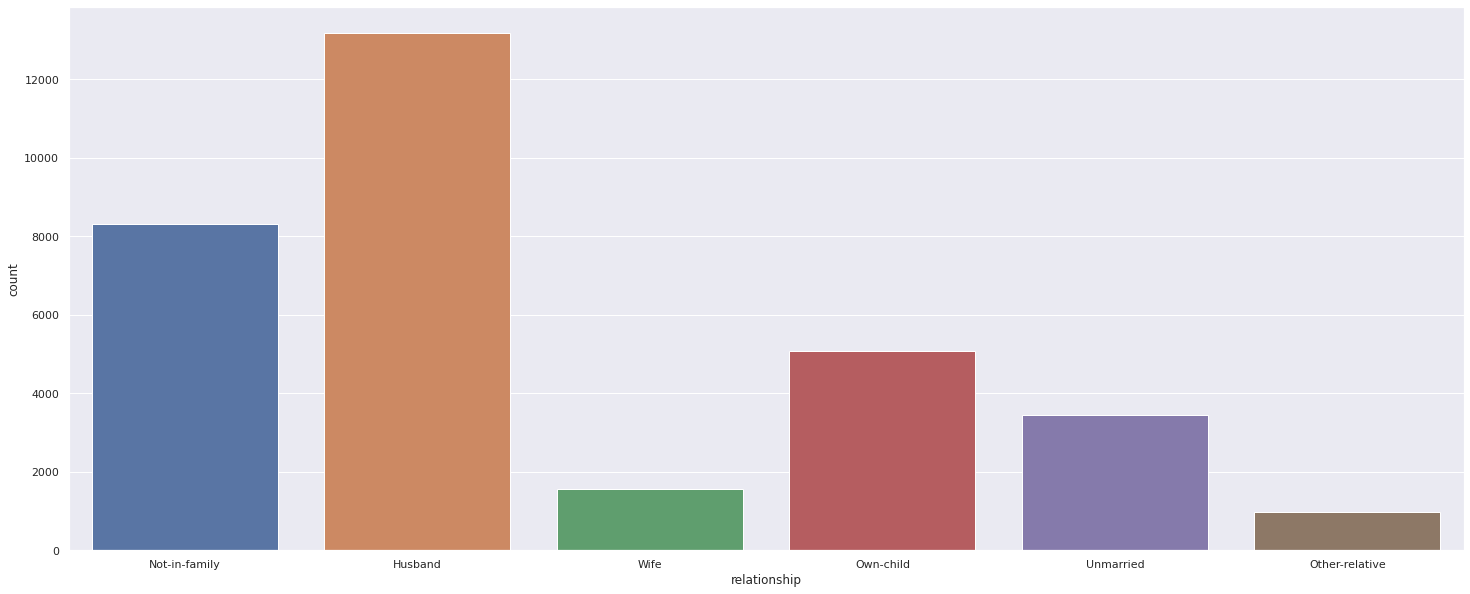

In [267]:
plt.figure(figsize=(25,10))
sns.countplot(data= df, x = "relationship")

Confirmed. A lot more males than females.

In [268]:
df['marital-status'].value_counts()

Married-civ-spouse       14975
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

<AxesSubplot:xlabel='marital-status', ylabel='count'>

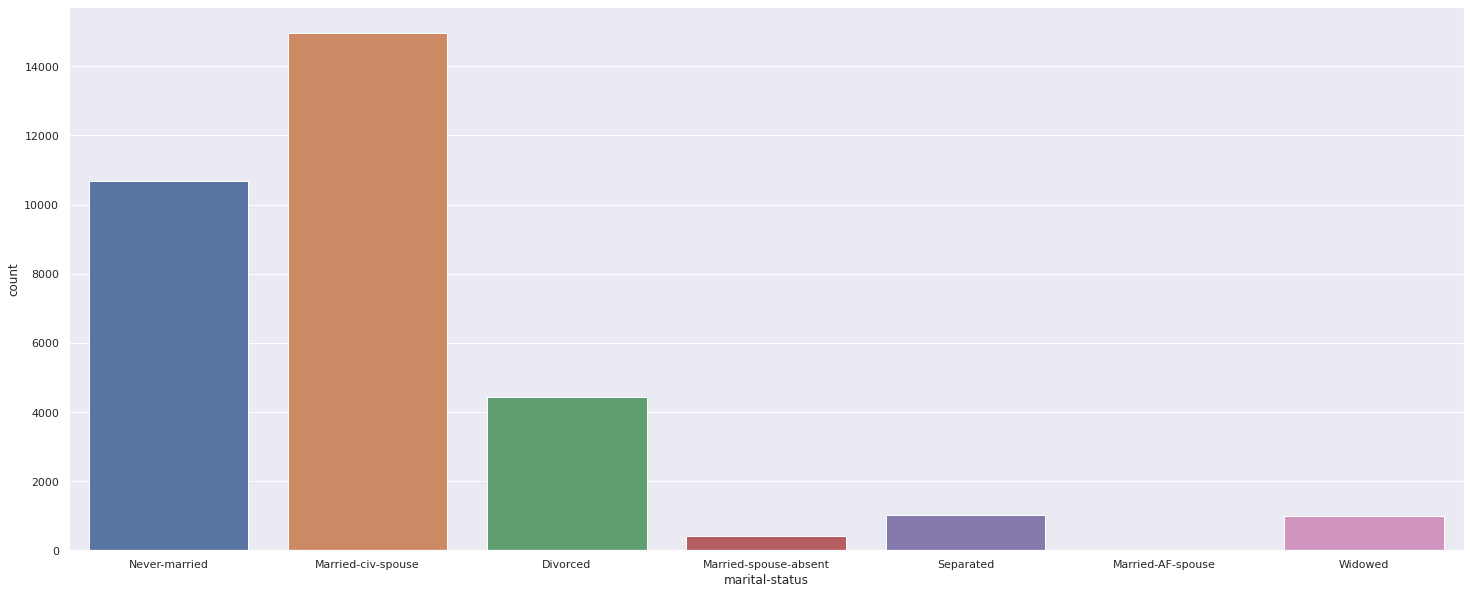

In [269]:
plt.figure(figsize=(25,10))
sns.countplot(data= df, x = "marital-status")

In [270]:
df['marital-status'] = df['marital-status'].replace(['Divorced','Never-married','Widowed'],'single')
df['marital-status'] = df['marital-status'].replace(['Married-civ-spouse','Separated','Married-spouse-absent','Married-AF-spouse'],'married')

Gahering everyone as single/married

In [271]:
df['marital-status'].value_counts()

married    16441
single     16119
Name: marital-status, dtype: int64

Good. Now the values are almost even.

In [272]:
df['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1115
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

<AxesSubplot:xlabel='workclass', ylabel='count'>

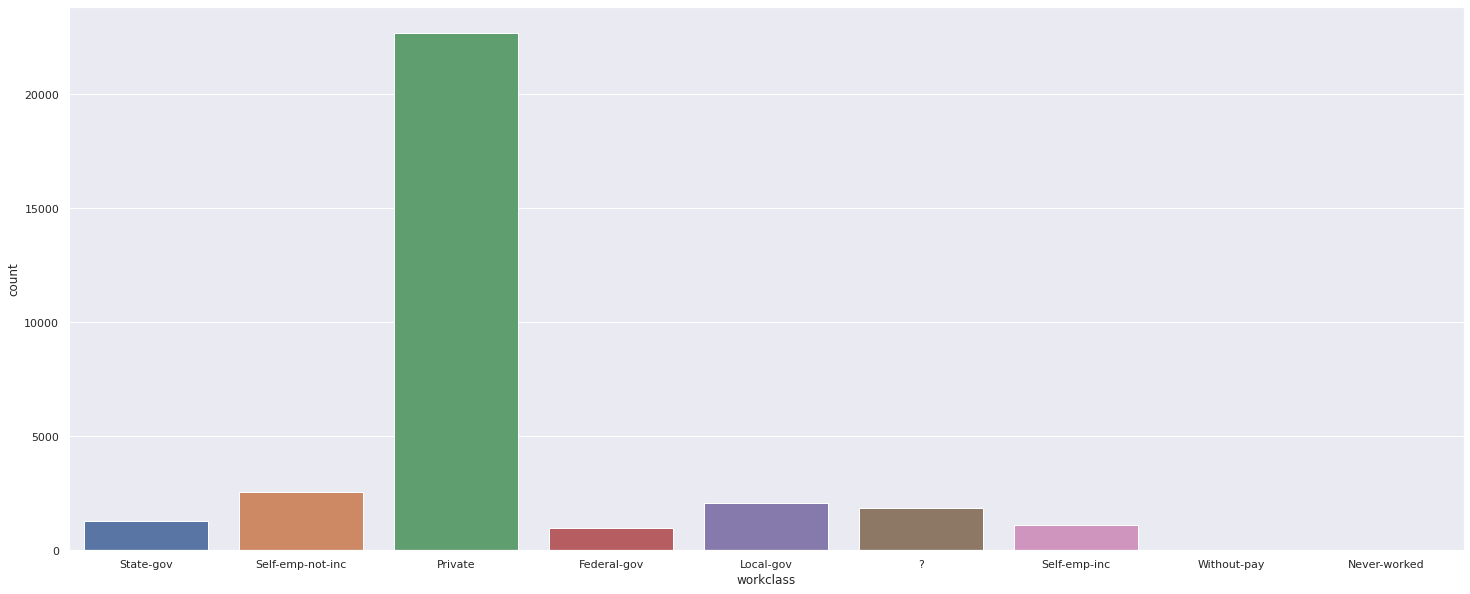

In [273]:
plt.figure(figsize=(25,10))
sns.countplot(data = df, x = df['workclass'])

In [274]:
df.drop(df.index[df['workclass'] == 'Without-pay'], inplace=True)
df.drop(df.index[df['workclass'] == 'Never-worked'], inplace=True)
df.drop(df.index[df['workclass'] == '?'], inplace=True)

Dropping 2 classes which do not earn any money, so they are irrelevant.
Also dropping '?' type of workclass, it could impact the model so I rather get rid of them.

In [275]:
df['native-country'].value_counts()

United-States                 27490
Mexico                          610
?                               556
Philippines                     187
Germany                         128
Puerto-Rico                     109
Canada                          107
India                           100
El-Salvador                     100
Cuba                             92
England                          86
Jamaica                          80
South                            71
China                            68
Italy                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        63
Japan                            59
Poland                           56
Columbia                         56
Iran                             42
Taiwan                           42
Haiti                            42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                      

I think it is safe to say that the data collected at the US. Therefore, I would remove everyone besides the US borned.

In [276]:
df=df[df['native-country']=='United-States']

Now, the column is useless, we will get ridd of it.

In [277]:
df=df.drop(columns='native-country',axis=1)

<AxesSubplot:xlabel='race', ylabel='count'>

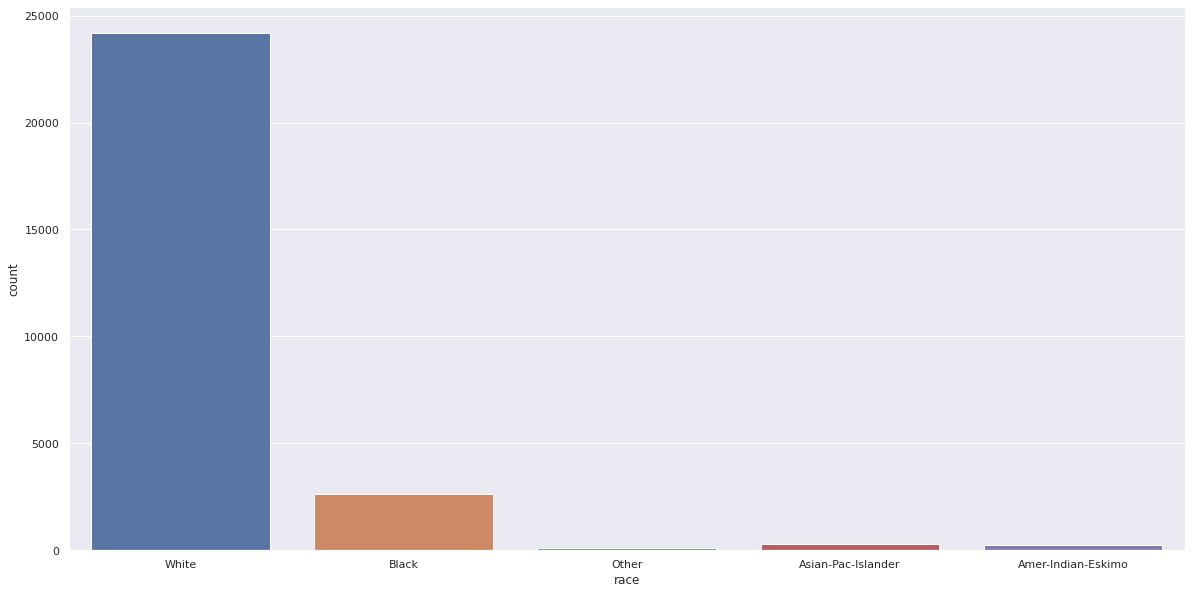

In [278]:
plt.figure(figsize = (20,10))
sns.countplot(data = df, x = df['race'])

A majority of white race noted

<AxesSubplot:xlabel='education', ylabel='count'>

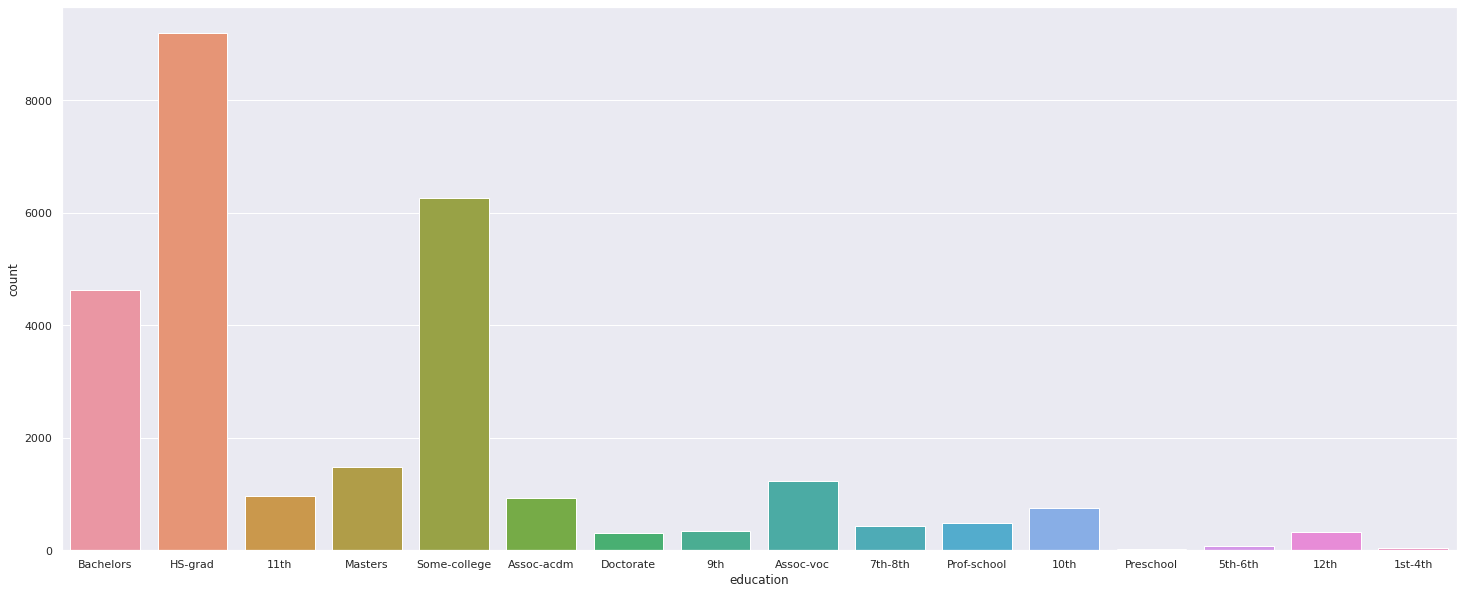

In [279]:
plt.figure(figsize = (25,10))
sns.countplot(data= df, x = "education")

A lot of education types. I will gather them by bins.

In [280]:
df['education'] = df['education'].replace(['1st-4th','5th-6th'],'elementary-school')
df['education'] = df['education'].replace(['7th-8th'],'middle-school')
df['education'] = df['education'].replace(['9th','10th','11th','12th'],'high-school')
df['education'] = df['education'].replace(['Doctorate','Bachelors','Some-college','Masters','Prof-school','Assoc-voc','Assoc-acdm'],'academic')
df.drop(df.index[df['education'] == 'Preschool'], inplace=True)

In [281]:
df['education'].value_counts()

academic             15332
HS-grad               9200
high-school           2390
middle-school          436
elementary-school      117
Name: education, dtype: int64

<AxesSubplot:xlabel='occupation', ylabel='count'>

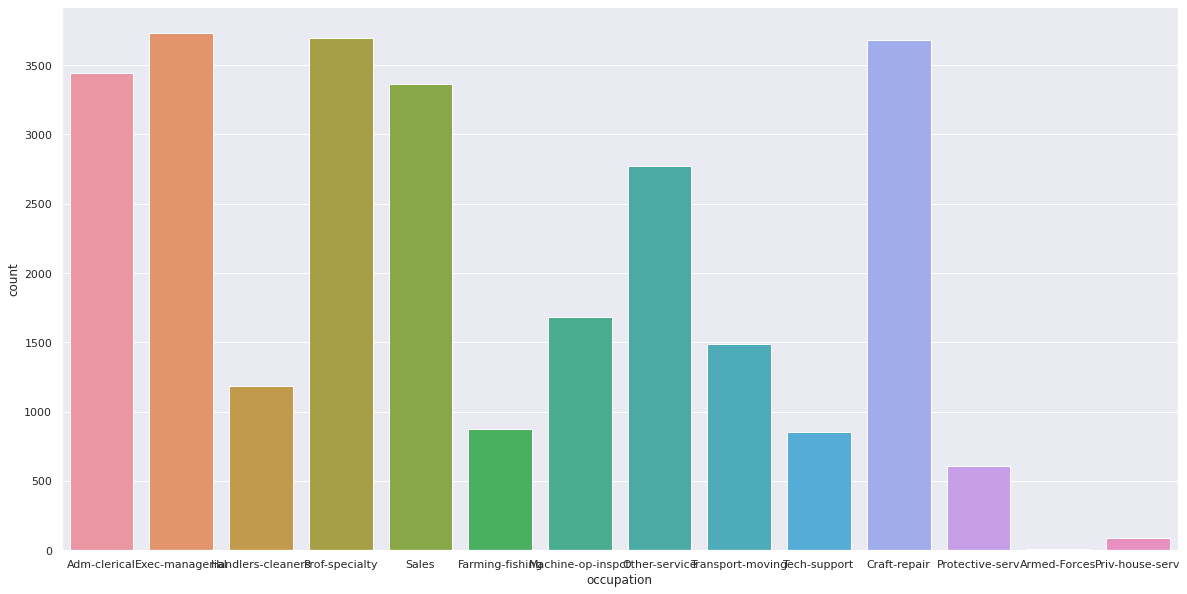

In [282]:
plt.figure(figsize=(20,10)) 
sns.countplot(data= df, x = "occupation")

In [283]:
numeric = ['age', 'fnlwgy', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'class']
categorical= ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']

In [284]:
df.head()

,ID,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,target
0,1,39,State-gov,77516,academic,13,single,Adm-clerical,Not-in-family,White,0,2174,0,40,0
1,2,50,Self-emp-not-inc,83311,academic,13,married,Exec-managerial,Husband,White,0,0,0,13,0
2,3,38,Private,215646,HS-grad,9,single,Handlers-cleaners,Not-in-family,White,0,0,0,40,0
3,4,53,Private,234721,high-school,7,married,Handlers-cleaners,Husband,Black,0,0,0,40,0
5,6,37,Private,284582,academic,14,married,Exec-managerial,Wife,White,1,0,0,40,0


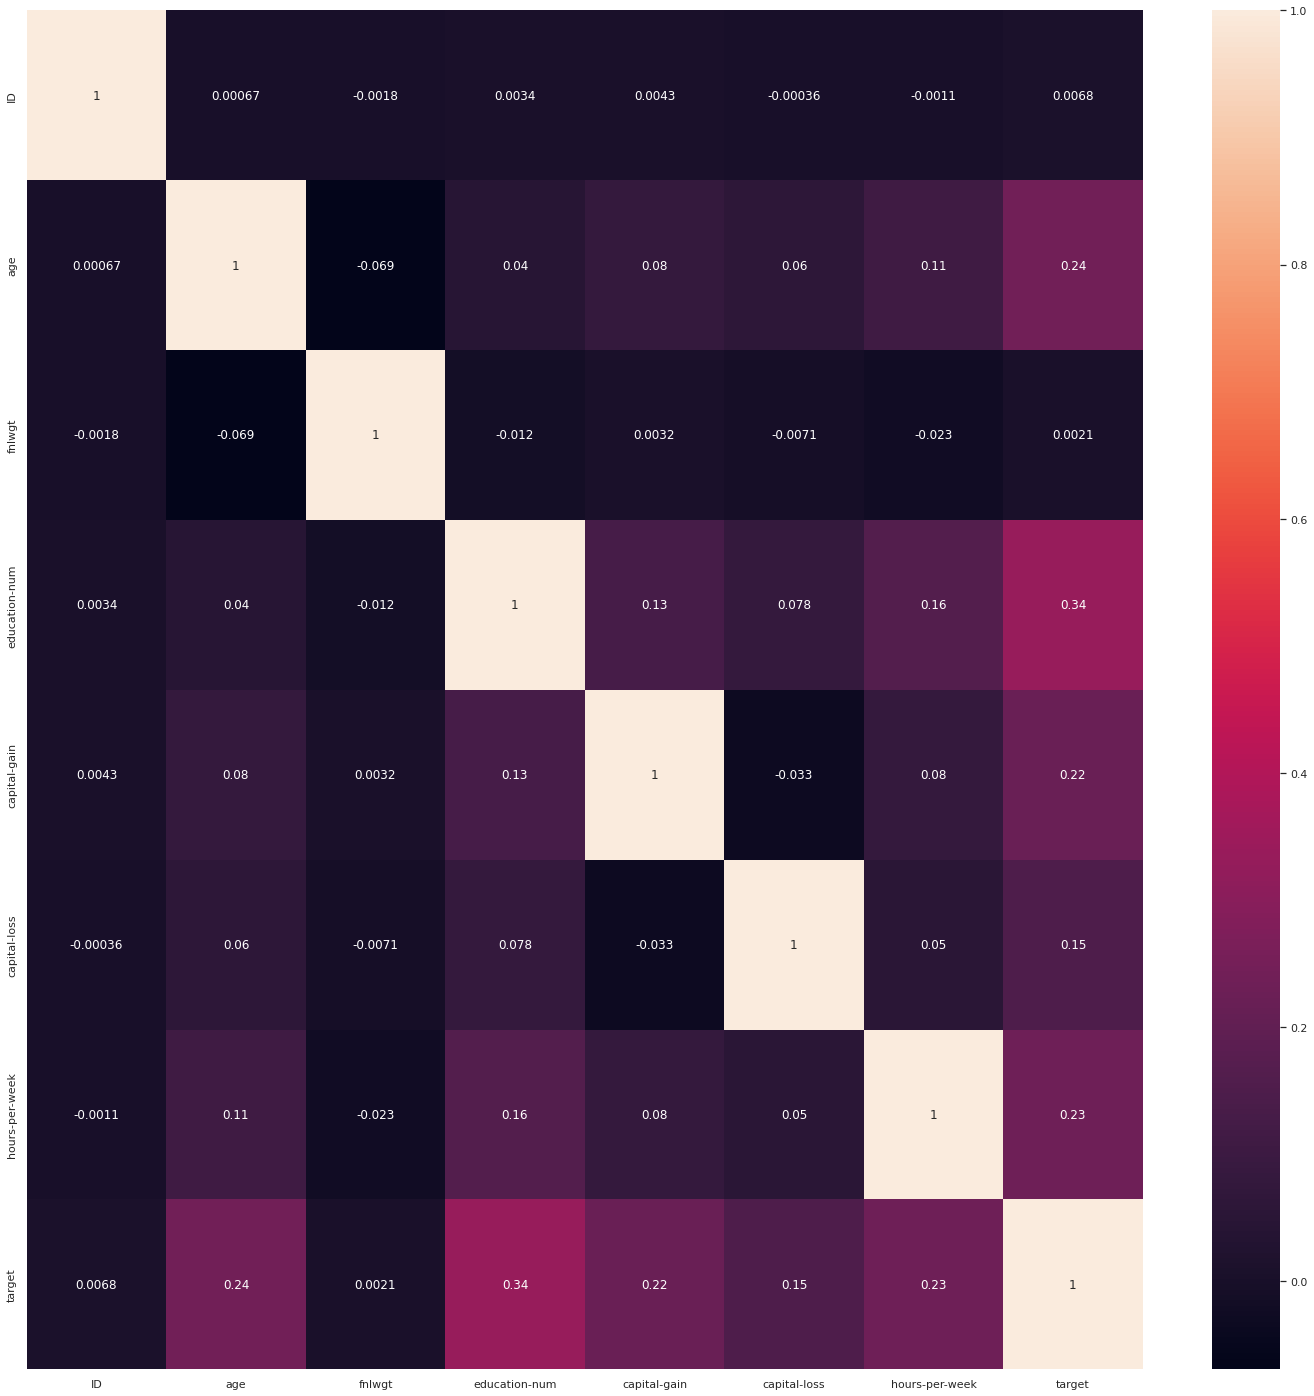

In [285]:
figure = plt.figure(figsize=(25,25))
corr_matrix = df.corr()
sns.heatmap(data=corr_matrix,annot=True)
plt.show()

Education seems to be the strongest corralation, yet not strong enough to be noted.

In [286]:
df = pd.get_dummies(data=df, columns=categorical)

Using dummies to create a sort of One-Hot for the categorical values

In [287]:
df.columns

Index(['ID', 'age', 'fnlwgt', 'education-num', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'target', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'education_HS-grad', 'education_academic',
       'education_elementary-school', 'education_high-school',
       'education_middle-school', 'marital-status_married',
       'marital-status_single', 'occupation_Adm-clerical',
       'occupation_Armed-Forces', 'occupation_Craft-repair',
       'occupation_Exec-managerial', 'occupation_Farming-fishing',
       'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
       'occupation_Other-service', 'occupation_Priv-house-serv',
       'occupation_Prof-specialty', 'occupation_Protective-serv',
       'occupation_Sales', 'occupation_Tech-support',
       'occupation_Transport-moving', 'relationship_Husband',
       'relationship_Not-in-family', 'r

In [288]:
preprocessPipeline = make_pipeline(custom_scaler(scaler_name='minmax'))

In [289]:
data_train, data_test = train_test_split(df, test_size = 0.4, stratify=df['target'], random_state=17)

In [290]:
data_val, data_test = train_test_split(data_test, test_size = 0.5, random_state=17)

In [291]:
data_train['target'].value_counts()

0    12289
1     4196
Name: target, dtype: int64

In [292]:
data_test['target'].value_counts().sum()

5495

In [293]:
data_train_target = data_train['target']
data_test_target = data_test['target']
data_val_target = data_val['target']


In [294]:
trainn = data_train_target
testt = data_test_target
vall=data_val_target

In [295]:
data_train = data_train.drop('target', axis = 1)
data_test = data_test.drop('target', axis = 1)
data_val = data_val.drop('target', axis = 1)

In [296]:
data_train = preprocessPipeline.fit_transform(data_train)
data_test = preprocessPipeline.transform(data_test)
data_val = preprocessPipeline.transform(data_val)

In [297]:
data_train.head()

,ID,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0.237661,0.150685,0.046747,0.571429,0.0,0.000000,0.0,0.397959,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.929205,0.589041,0.265310,0.500000,0.0,0.105201,0.0,0.397959,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.262262,0.068493,0.025387,0.571429,1.0,0.000000,0.0,0.397959,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.585982,0.082192,0.028347,0.571429,0.0,0.000000,0.0,0.397959,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.984797,0.438356,0.054299,0.785714,1.0,0.000000,0.0,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [299]:
print(data_train.shape)
print(type(trainn.shape))
trainn

(16485, 46)
<class 'tuple'>


7738     0
30254    1
8539     0
19079    0
32064    0
        ..
9103     0
21702    0
16011    0
29849    0
26258    0
Name: target, Length: 16485, dtype: int64

In [315]:
# def __getitem__(x,y ,index):
#     x, y = x[index], y[index]
#     return x, y
# x, y = __getitem__(data_train.values,trainn.values,1521)
# x, y

def __getitem__(x,index):
    x = x[index]
    return x
__getitem__(data_val.values,0)

array([0.37574864, 0.1369863 , 0.1073371 , 0.5       , 1.        ,
       0.        , 0.        , 0.41836735, 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        ])

In [316]:
clf = TabNetClassifier()  #TabNetRegressor()
clf.fit(data_train.values, trainn.values)

clf.fit(
  data_train.values, trainn.values,
  eval_set=[(data_val.values, vall.values)]
)
preds = clf.predict(data_test.values)

print(roc_auc_score(testt,preds))

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.56263 |  0:00:00s
epoch 1  | loss: 0.44226 |  0:00:01s
epoch 2  | loss: 0.41832 |  0:00:01s
epoch 3  | loss: 0.39038 |  0:00:02s
epoch 4  | loss: 0.36874 |  0:00:03s
epoch 5  | loss: 0.35905 |  0:00:03s
epoch 6  | loss: 0.35481 |  0:00:04s
epoch 7  | loss: 0.35192 |  0:00:05s
epoch 8  | loss: 0.35075 |  0:00:05s
epoch 9  | loss: 0.34611 |  0:00:06s
epoch 10 | loss: 0.3437  |  0:00:07s
epoch 11 | loss: 0.3399  |  0:00:07s
epoch 12 | loss: 0.3408  |  0:00:08s
epoch 13 | loss: 0.34188 |  0:00:09s
epoch 14 | loss: 0.34105 |  0:00:09s
epoch 15 | loss: 0.33285 |  0:00:10s
epoch 16 | loss: 0.33229 |  0:00:10s
epoch 17 | loss: 0.33683 |  0:00:11s
epoch 18 | loss: 0.33341 |  0:00:12s
epoch 19 | loss: 0.33803 |  0:00:12s
epoch 20 | loss: 0.335   |  0:00:13s
epoch 21 | loss: 0.3297  |  0:00:13s
epoch 22 | loss: 0.33003 |  0:00:14s
epoch 23 | loss: 0.32623 |  0:00:15s
epoch 24 | loss: 0.32

In [323]:
preds = clf.predict_proba(data_test.values)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=testt)
test_auc

0.8974167329336922

In [327]:
explain_matrix, masks = clf.explain(data_val.values)

In [387]:
d = {'col1':list(data_test.columns) , 'tabnet':list(clf.feature_importances_),'catboost':list(cat_df['feature_importance'])}
df = pd.DataFrame(data=d)
df=df.sort_values(by='tabnet')

In [388]:
df

,col1,tabnet,catboost
45,race_White,0.000000e+00,27.951854
17,education_high-school,0.000000e+00,0.190825
16,education_elementary-school,0.000000e+00,0.187516
29,occupation_Priv-house-serv,0.000000e+00,0.603269
14,education_HS-grad,0.000000e+00,0.136278
30,occupation_Prof-specialty,0.000000e+00,0.728364
31,occupation_Protective-serv,0.000000e+00,0.741641
11,workclass_Self-emp-inc,0.000000e+00,0.024832
32,occupation_Sales,0.000000e+00,0.921671
9,workclass_Local-gov,0.000000e+00,0.000000


In [389]:
plt.figure(figsize=(15,15))
plt.barh(df['col1'],df['col2'])
plt.barh(cat_df['feature_names'],cat_df['feature_importance'])
plt.legend(['df','cat'])
#plt.yticks(range(len(clf.feature_importances_)),clf.feature_importances_)

KeyError: 'col2'

<Figure size 1080x1080 with 0 Axes>

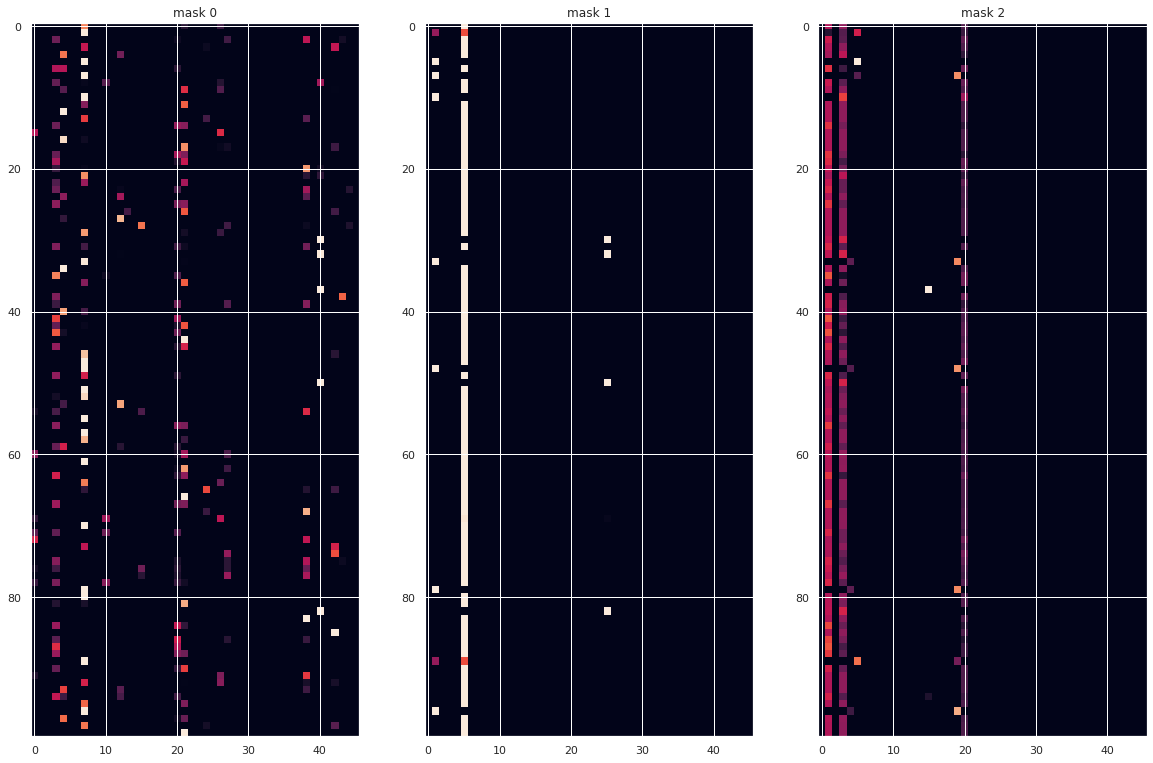

In [331]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:100])
    axs[i].set_title(f"mask {i}")

In [106]:
data_test.head()

,ID,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,0.134801,0.205479,0.022461,0.500000,0.0,1.0,0.000000,0.397959,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.783378,0.013699,0.050902,0.571429,0.0,0.0,0.000000,0.142857,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.090267,0.273973,0.015786,0.571429,0.0,0.0,0.000000,0.397959,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.465831,0.383562,0.103925,0.500000,1.0,0.0,0.000000,0.346939,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.929789,0.205479,0.097010,0.500000,0.0,0.0,0.436639,0.500000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
data_train['target'] = trainn
data_test['target'] = testt

In [44]:
x_train = data_train.copy()
x_test = data_test.copy()
y_train = data_train['target'].copy()
y_test = data_test['target'].copy()

In [45]:
x_train = x_train.drop('target', axis = 1)
x_test = x_test.drop('target', axis = 1)

In [46]:
scoring = 'roc_auc'
params_lgr = [
    {
        'penalty': ['l1','l2'],
        'solver' : ['liblinear'],
        'C': [0.001,0.01,0.1,1, 0.0001],
        'class_weight': ['balanced'],
        'max_iter': [10000]
    }
]

clf_logistic = GridSearchCV(LogisticRegression(verbose=True), params_lgr, scoring=scoring,
                            return_train_score=True, verbose=10, cv=5, n_jobs =-1)

clf_logistic.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  33 out of  50 | elapsed:    6.8s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  39 out of  50 | elapsed:    7.2s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:    7.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.8s finished


[LibLinear]

GridSearchCV(cv=5, estimator=LogisticRegression(verbose=True), n_jobs=-1,
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 0.0001],
                          'class_weight': ['balanced'], 'max_iter': [10000],
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             return_train_score=True, scoring='roc_auc', verbose=10)

In [47]:
clf_logistic.cv_results_['params'][clf_logistic.best_index_]

{'C': 1,
 'class_weight': 'balanced',
 'max_iter': 10000,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [48]:
gs_logistic_results = clf_logistic.best_estimator_

In [49]:
clfs = gs_logistic_results
%time clfs.fit(x_train, y_train.values)

[LibLinear]Wall time: 6.23 s


LogisticRegression(C=1, class_weight='balanced', max_iter=10000, penalty='l1',
                   solver='liblinear', verbose=True)

In [50]:
y_pred = clfs.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      5120
           1       0.58      0.85      0.69      1749

    accuracy                           0.81      6869
   macro avg       0.76      0.82      0.77      6869
weighted avg       0.85      0.81      0.82      6869



As it seems, we have a high recall and a good trade-off between the precision and recall, and a decent f1-score, model seems good.

In [51]:
data_test['pred'] = y_pred

In [52]:
cm=metrics.confusion_matrix(y_test,y_pred)
print(cm)

[[4049 1071]
 [ 265 1484]]


In [53]:
lgr_accuracy = metrics.accuracy_score(y_test,y_pred)
print(round((lgr_accuracy*100),3))

80.55


In [54]:
print(roc_auc_score(y_test, clfs.predict_proba(x_test)[:, 1]))

0.9041927976700972


So we have 90% roc_auc score and 80.5% accuracy with a high recall and prcision.

In [55]:
data_test['pred'].value_counts()

0    4314
1    2555
Name: pred, dtype: int64

In [56]:
data_test['target'].value_counts()

0    5120
1    1749
Name: target, dtype: int64

To sum up, that is a pretty good model. This is my submition.
If I had the time, I would do cross-validation and try other things like Shap for model evaluation.

I am sorry for the things I said in our phonecall after blacking-out, I hope this model would show that I do understand what is recall and regularization.

I will love to hear from you back :)

Thank you

In [373]:
from catboost import CatBoostClassifier,Pool

In [367]:
model = CatBoostClassifier(iterations=20,
                           depth=5,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)
# train the model
model.fit(data_train.values, trainn.values)
# make the prediction using the resulting model
preds_class = model.predict(data_test.values)
preds_proba = model.predict_proba(data_test.values)
print(roc_auc_score(testt,preds_proba[:,1]))
#print("class = ", preds_class)
#print("proba = ", preds_proba)
# data_train
# data_test
# data_val

0:	learn: 0.3724352	total: 3.59ms	remaining: 68.1ms
1:	learn: 0.3461275	total: 8.82ms	remaining: 79.4ms
2:	learn: 0.3367742	total: 14.7ms	remaining: 83.5ms
3:	learn: 0.3265315	total: 28.3ms	remaining: 113ms
4:	learn: 0.3226687	total: 35.2ms	remaining: 106ms
5:	learn: 0.3144655	total: 40ms	remaining: 93.4ms
6:	learn: 0.3111525	total: 48ms	remaining: 89.2ms
7:	learn: 0.3083472	total: 55.9ms	remaining: 83.8ms
8:	learn: 0.3046588	total: 65.5ms	remaining: 80.1ms
9:	learn: 0.2993225	total: 71.3ms	remaining: 71.3ms
10:	learn: 0.2970685	total: 85.6ms	remaining: 70ms
11:	learn: 0.2946757	total: 91ms	remaining: 60.7ms
12:	learn: 0.2921124	total: 115ms	remaining: 61.8ms
13:	learn: 0.2906209	total: 120ms	remaining: 51.2ms
14:	learn: 0.2830607	total: 129ms	remaining: 42.9ms
15:	learn: 0.2816478	total: 140ms	remaining: 34.9ms
16:	learn: 0.2798998	total: 145ms	remaining: 25.5ms
17:	learn: 0.2780391	total: 151ms	remaining: 16.8ms
18:	learn: 0.2762737	total: 157ms	remaining: 8.29ms
19:	learn: 0.2748268

In [378]:

cat_df=pd.DataFrame({'feature_importance': model.get_feature_importance(Pool(data_train, trainn)), 
              'feature_names': data_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=True)

<BarContainer object of 46 artists>

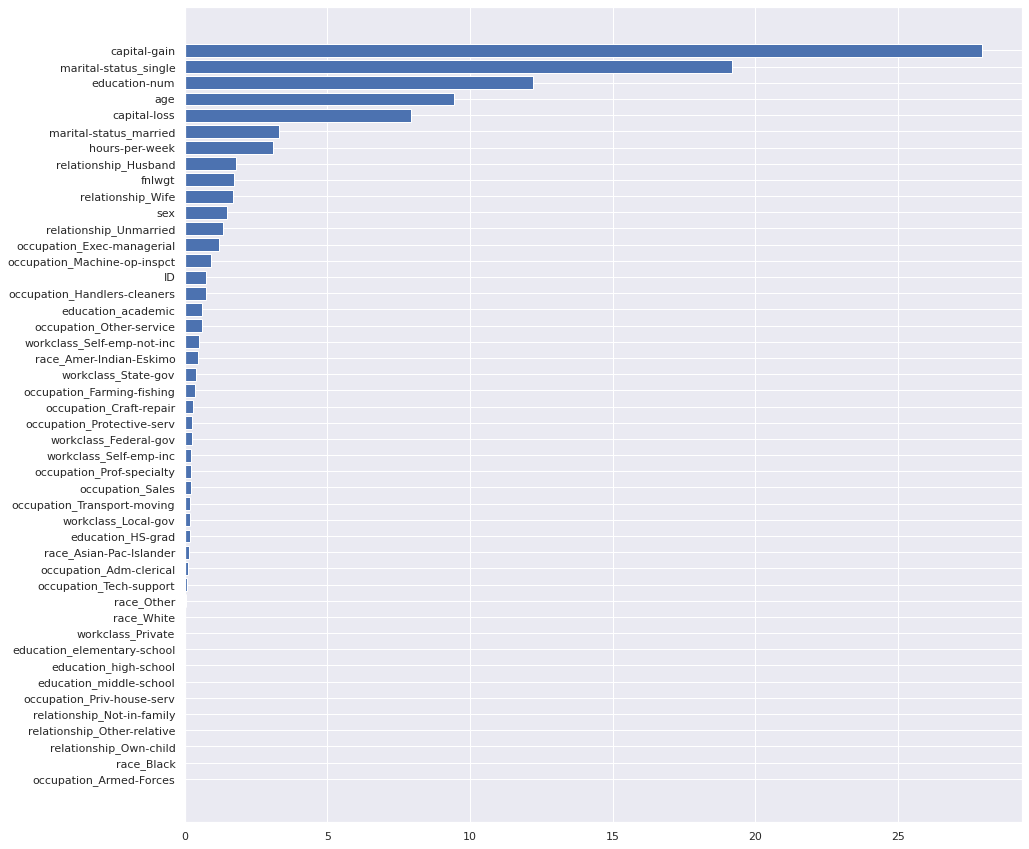

In [383]:
plt.figure(figsize=(15,15))
plt.barh(cat_df['feature_names'],cat_df['feature_importance'])